<h1>What's for dinenr?</h1>
<h4><i> An simple LSTM model generates dinner suggestions from partial ingredient list </i><h4>
<h4><br></h4>
<h2>Introduction</h2>


<h2>Data Cleaning</h2>
<h3> Ingredient Data </h3>

In [163]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle

import tensorflow as tf
import gensim.downloader as api
from gensim.models import Word2Vec
import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Masking
from tensorflow.keras.models import Model
from keras.preprocessing.text import Tokenizer

import seaborn as sns
from wordcloud import WordCloud

In [164]:
#precleaned dataframe from authors is used to clean data.
precleaned_key = pd.read_pickle('ingr_map.pkl')
cleaning_key = dict(zip(precleaned_key['raw_ingr'],precleaned_key['replaced']))
precleaned_key[['raw_ingr','replaced']]

,raw_ingr,replaced
0,"medium heads bibb or red leaf lettuce, washed,...",lettuce
1,mixed baby lettuces and spring greens,lettuce
2,romaine lettuce leaf,lettuce
3,iceberg lettuce leaf,lettuce
4,red romaine lettuce,lettuce
...,...,...
11654,soybeans,soybean
11655,goose,goose
11656,ajwain,ajwain
11657,brinjals,brinjal


In [165]:
class CleanRecipes():
    '''Imports and cleans raw recipe data. Returns list of ingredients.'''
    def __init__(self,cleaning_key=cleaning_key): 
        self.raw_recipes = self.import_data()
        self.input_sequences = self.raw_recipes['ingredients'].apply(self.string_to_list).to_list()
        print(self.input_sequences)
        self.cleaned_ingredients = []
        self.cleaning_key = cleaning_key

    def __call__(self):
        self.cleaned_ingredients = self.clean_text()
        return self.raw_recipes, self.input_sequences, self.cleaned_ingredients

    def import_data(self):
        #'''Import cleaned recipe, raw recipe and ratings data'''
        raw_recipes = pd.read_csv('RAW_recipes.csv')
        del raw_recipes['contributor_id']
        del raw_recipes['submitted']
        del raw_recipes['tags']
        del raw_recipes['steps']
        del raw_recipes['description']
        raw_recipes = raw_recipes.set_index('id')
        return raw_recipes

    def string_to_list(self,s):
        '''Converts a string that is formatted like a list to a list'''
        l = re.findall(r'\w[\w\s]+',s)
        return l

    def clean_text(self):
        #all_ingredients = [x for sublist in self.input_sequences for x in sublist]
        for recipe in self.input_sequences:
            ingredient_bundle = []
            for ingredient in recipe:
                try:
                    ingredient_bundle.append(self.cleaning_key[ingredient])
                except:
                    ingredient_bundle.append(ingredient)
            self.cleaned_ingredients.append(ingredient_bundle)
        return self.cleaned_ingredients

In [166]:
#Import and clean all recipes
raw_recipes, input_sequences, cleaned_sequences = CleanRecipes()()
cleaned_sequences[:1]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['winter squash',
  'mexican seasoning',
  'mixed spice',
  'honey',
  'butter',
  'olive oil',
  'salt']]

<h3><br><h3>
<h3> Cleaning recipe names </h3>

In [167]:
#removing extra spaces
class CleanNames():
    '''Takes raw recipe names and returns cleaned, single words in a list with EOS and SOS tags'''
    def __init__(self):
        self.names = raw_recipes['name'].to_list()
        self.cleaned_names = []
        
    def __call__(self):
        for name in self.names:
            name = self.de_contract(name)
            name = self.add_tags(name)
            name = list(filter(self.empty_check,str(name).split(' ')))
            self.cleaned_names.append(name)
        return self.cleaned_names
        
    def de_contract(self,name):
        '''Removes common contractions from recipe names'''
        s = str(name)
        s = s.replace('can t','cannot')
        s = s.replace('don t','do not')
        s = s.replace('it s','it is')
        s = s.replace('won t','would not')
        s = s.replace('aren t','are not')
        s = s.replace('there s','there is')
        s = s.replace('you d', 'you would')
        s = s.replace('you ve', 'you have')
        s = s.replace('you ll', 'you will')
        return s      
    
    def add_tags(self,name):
        '''Adds SOS and EOS tags'''
        name = 'SOS '+name+' EOS'
        return name
    
    def empty_check(self,s):
        '''Checks if word is only a space'''
        if s != '':
            return True
        else: return False

In [168]:
cleaned_names = CleanNames()()
cleaned_names[:10]

[['SOS', 'arriba', 'baked', 'winter', 'squash', 'mexican', 'style', 'EOS'],
 ['SOS', 'a', 'bit', 'different', 'breakfast', 'pizza', 'EOS'],
 ['SOS', 'all', 'in', 'the', 'kitchen', 'chili', 'EOS'],
 ['SOS', 'alouette', 'potatoes', 'EOS'],
 ['SOS', 'amish', 'tomato', 'ketchup', 'for', 'canning', 'EOS'],
 ['SOS', 'apple', 'a', 'day', 'milk', 'shake', 'EOS'],
 ['SOS', 'aww', 'marinated', 'olives', 'EOS'],
 ['SOS', 'backyard', 'style', 'barbecued', 'ribs', 'EOS'],
 ['SOS', 'bananas', '4', 'ice', 'cream', 'pie', 'EOS'],
 ['SOS', 'beat', 'this', 'banana', 'bread', 'EOS']]

<h2><br></h2>
<h2>EDA</h2>
<h3>Sequence lengths</h3>

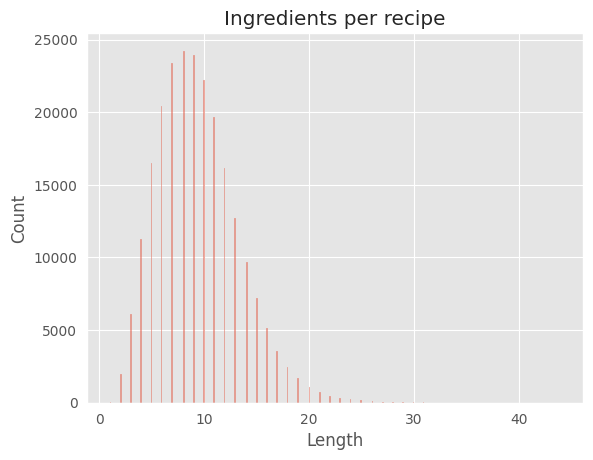

In [169]:
#ingredient list length
lengths = [len(x) for x in cleaned_sequences]
plt.style.use('ggplot')
sns.histplot(pd.DataFrame(lengths),legend=False)
plt.title('Ingredients per recipe')
plt.xlabel('Length')
plt.show()

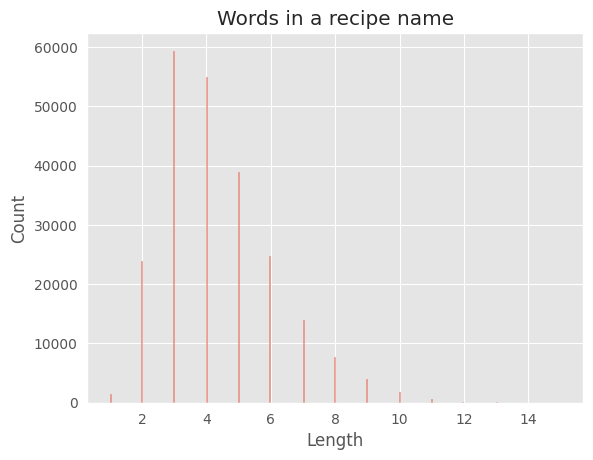

In [170]:
#Recipe name length
lengths = [len(x)-2 for x in cleaned_names]
plt.style.use('ggplot')
sns.histplot(pd.DataFrame(lengths),legend=False)
plt.title('Words in a recipe name')
plt.xlabel('Length')
plt.show()

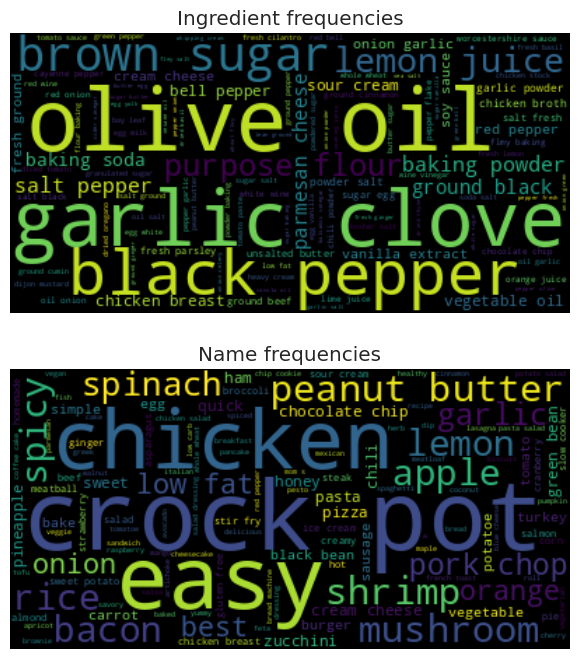

In [171]:
#word cloud by word freqency
all_words = ' '.join([x for sublist in cleaned_sequences for x in sublist])
all_names = ' '.join([x for sublist in cleaned_names for x in sublist if x != 'EOS' if x != 'SOS'])
wordcloud = WordCloud().generate(all_words)
namecloud = WordCloud().generate(all_names)
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ingredient frequencies')
plt.subplot(2,1,2)
plt.imshow(namecloud, interpolation='bilinear')
plt.axis('off')
plt.title('Name frequencies');

In [172]:
#top words
def get_top(cleaned_sequences):
    '''Returns a sorted list of ingredients by occurance'''
    ingred = [x for sublist in cleaned_sequences for x in sublist]
    ingred_counts = Counter(ingred).most_common()
    #top_ingredients = [ingred_counts[n][0] for n in range(len(ingred_counts))]
    return ingred_counts

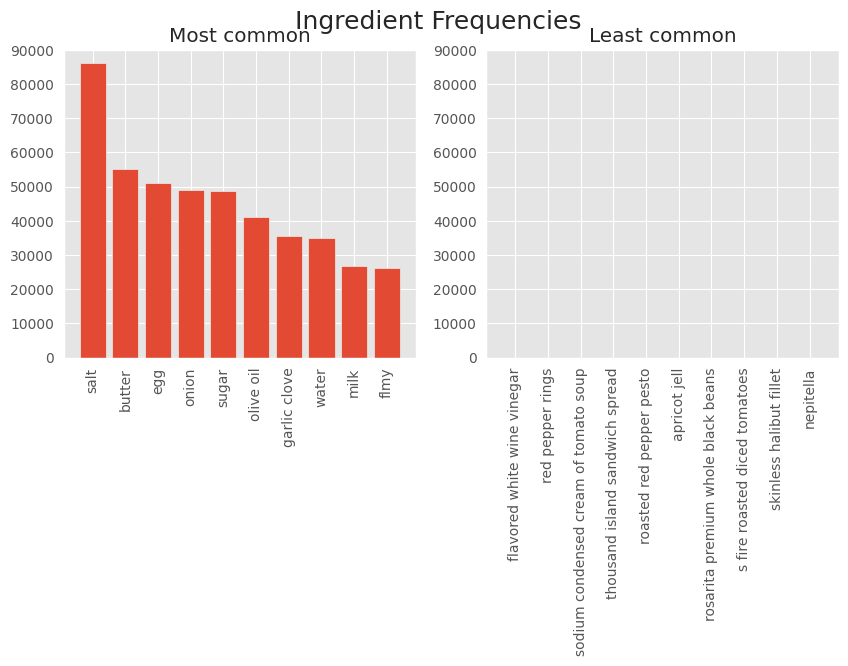

In [173]:
tops = get_top(cleaned_sequences)
sorted_ingredients = [x[0] for x in tops]
sorted_counts = [x[1] for x in tops]

count_range = 10 
plt.figure(figsize=(10,4))
plt.style.use('ggplot')
plt.suptitle('Ingredient Frequencies',fontsize=18)
plt.subplot(1,2,1)
plt.bar(sorted_ingredients[:count_range], sorted_counts[:count_range])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Most common')

plt.subplot(1,2,2)
plt.bar(sorted_ingredients[-count_range:], sorted_counts[-count_range:])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Least common');

<h2><br></h2>
<h2>Preprocessing text</h2>
<h3>Tokenizing recipes and names</h3>

In [174]:
pad_value = int(0)

In [175]:
class TokenizeRecipes():
    def __init__(self, input_sequences, ngram=True):
        self.tokenizer = Tokenizer()
        self.input_sequences = input_sequences
        self.ngram = ngram
    
    def __call__(self, names=False):
        self.tokenizer, self.ngram_sequences, self.totalwords = self.get_sequence_of_tokens()
        self.max_length = self.find_max()
        self.padded_sequence = self.pad_sequences()
        self.padded_sequence = np.array(self.padded_sequence)
        self.predictors, self.label = self.padded_sequence[:,:-1],self.padded_sequence[:,-1]
        if names:
            self.predictors, self.label = self.delete_only_ones()
        return self.tokenizer, self.max_length, self.totalwords, self.label, self.predictors, self.padded_sequence

    def get_sequence_of_tokens(self):
        '''Tokenization'''    
        self.tokenizer.fit_on_texts(self.input_sequences)
        self.total_words = len(self.tokenizer.word_index) + 1

        self.ngram_sequences = []
        for line in self.input_sequences:
            token_list = self.tokenizer.texts_to_sequences([line])[0]
            if self.ngram:
                for i in range(1, len(token_list)):
                    n_gram_sequence = token_list[:i+1]
                    self.ngram_sequences.append(n_gram_sequence)
            else: self.ngram_sequences.append(token_list)
        return self.tokenizer, self.ngram_sequences, self.total_words

    def find_max(self):
        '''find max token length'''
        self.max_length = max(len(x) for x in self.input_sequences)
        return self.max_length

    def pad_sequences(self):
        '''pad sequences (built in function returns a recursion error)'''
        self.padded_sequence = []
        for sequence_in in self.ngram_sequences:
            zeros = (self.max_length-len(sequence_in))
            padded = [pad_value for zero in range(zeros+1)]
            padded.extend(sequence_in)
            self.padded_sequence.append(padded)
        return self.padded_sequence
    
    def delete_only_ones(self):
        to_be_deleted = []
        for i in range(len(self.predictors)):
            if self.predictors[i][-1] == 1:
                to_be_deleted.append(i)
                
        self.predictors = np.delete(self.predictors, to_be_deleted, axis=0)
        self.label = np.delete(self.label, to_be_deleted, axis=0)
        return self.predictors, self.label

In [176]:
#tokenizing ingredients
tokenizer,max_length_,total_words,label,predictors,_ = TokenizeRecipes(cleaned_sequences)()
total_words, max_length_, len(label), len(predictors)

(12413, 44, 1948345, 1948345)

In [177]:
#tokenize names
tokenizer_names, max_length_name_, total_words_names,_,_,name_sequences = TokenizeRecipes(cleaned_names, ngram=False)()
#_, _, _, _, padded_names = TokenizeRecipes(cleaned_names, ngram=False)(names=True)
_,_,_,_,_,recipe_sequences = TokenizeRecipes(cleaned_sequences, ngram=False)()
print(recipe_sequences.shape, name_sequences.shape)

(231637, 45) (231637, 18)


In [178]:
recipe_sequences

array([[   0,    0,    0, ...,    2,    6,    1],
       [   0,    0,    0, ...,    9,   18,  141],
       [   0,    0,    0, ...,    1,   74,   23],
       ...,
       [   0,    0,    0, ...,    1,   26,  657],
       [   0,    0,    0, ...,  516,  618, 2373],
       [   0,    0,    0, ...,  316,   21,   33]])

In [179]:
name_sequences

array([[   0,    0,    0, ...,  109,   45,    2],
       [   0,    0,    0, ...,  122,   72,    2],
       [   0,    0,    0, ...,  953,   56,    2],
       ...,
       [   0,    0,    0, ...,  486,  127,    2],
       [   0,    0,    0, ...,   39, 1459,    2],
       [   0,    0,    0, ...,  467,   17,    2]])

In [180]:
'''
recipe_counts = [sum([name!=0 for name in names])for names in padded_names]

iterated_recipes = []
for n,num in enumerate(recipe_counts):
    for _ in range(num):
        iterated_recipes.append(list(recipe_sequences[n]))

iterated_recipes = np.array(iterated_recipes)
iterated_recipes.shape
'''

'\nrecipe_counts = [sum([name!=0 for name in names])for names in padded_names]\n\niterated_recipes = []\nfor n,num in enumerate(recipe_counts):\n    for _ in range(num):\n        iterated_recipes.append(list(recipe_sequences[n]))\n\niterated_recipes = np.array(iterated_recipes)\niterated_recipes.shape\n'

<h3>Embedding text using word2vec</h3>

In [181]:
api.info(name_only=True)

{'corpora': ['semeval-2016-2017-task3-subtaskBC',
  'semeval-2016-2017-task3-subtaskA-unannotated',
  'patent-2017',
  'quora-duplicate-questions',
  'wiki-english-20171001',
  'text8',
  'fake-news',
  '20-newsgroups',
  '__testing_matrix-synopsis',
  '__testing_multipart-matrix-synopsis'],
 'models': ['fasttext-wiki-news-subwords-300',
  'conceptnet-numberbatch-17-06-300',
  'word2vec-ruscorpora-300',
  'word2vec-google-news-300',
  'glove-wiki-gigaword-50',
  'glove-wiki-gigaword-100',
  'glove-wiki-gigaword-200',
  'glove-wiki-gigaword-300',
  'glove-twitter-25',
  'glove-twitter-50',
  'glove-twitter-100',
  'glove-twitter-200',
  '__testing_word2vec-matrix-synopsis']}

In [182]:
embed_model = api.load('word2vec-google-news-300')

In [183]:
embed_size = 300

In [184]:
'''
#tokenizing recipe name
tokenizer_name, max_length_name_, total_words_name, label_name, predictors_name = TokenizeRecipes(cleaned_names)()
total_words_name, max_length_name_
'''

'\n#tokenizing recipe name\ntokenizer_name, max_length_name_, total_words_name, label_name, predictors_name = TokenizeRecipes(cleaned_names)()\ntotal_words_name, max_length_name_\n'

In [185]:
class EmbedWords():
    def __init__(self,cleaned_sequences, embed_size=embed_size,embed_model=embed_model, tokenizer=tokenizer):
        self.cleaned_sequences = cleaned_sequences
        self.embed_size = embed_size
        self.embed_model = embed_model
        self.word_index = tokenizer.word_index.items()
        self.unique_words = self.find_unique_word()
       
    def __call__(self):
        self.word_embeddings = self.encode_words()
        return self.unique_words, self.word_embeddings
        
    def embed_one_word(self,word):
        '''Encode a single recipe'''
        self.word_embedding = []
        try:
            self.word_embedding.append(self.embed_model[word])
        except:
            self.word_embedding.append(np.zeros((self.embed_size)))
        return self.word_embedding
    
    def find_unique_word(self):
        '''Lists unique words'''
        return list(set([x for sublist in self.cleaned_sequences for x in sublist]))
    
    def encode_words(self):
        '''Encode all recipes'''
        self.word_embeddings = np.zeros((len(self.unique_words)+1,self.embed_size))
        for word,i in self.word_index:
            self.word_embeddings[i,:] = self.embed_one_word(word)[0]
        return self.word_embeddings
    

In [186]:
#creating embeding matrices
unique_ingredients,recipe_embeddings = EmbedWords(cleaned_sequences)()
unique_names, name_embeddings = EmbedWords(cleaned_names)()

In [187]:
def shuffle(l):
    dim = max((l[0].shape[0],l[0].shape[1]))
    idx = np.random.permutation(dim)
    l = [item[idx-1] for item in l]
    return l

predictors, label = shuffle([predictors,label])
#recipe_sequences, name_sequences = shuffle(recipe_sequences, name_sequences)
predictors.shape, label.shape

((1948345, 44), (1948345,))

In [188]:
#shape of ingredient data
predictors.shape, label.shape, recipe_embeddings.shape,len(unique_ingredients)

((1948345, 44), (1948345,), (12413, 300), 12412)

In [189]:
#shape of recipe names data
name_sequences.shape, recipe_sequences.shape, name_embeddings.shape,len(unique_names), recipe_embeddings.shape, len(unique_ingredients)

((231637, 18), (231637, 45), (28954, 300), 28953, (12413, 300), 12412)

In [190]:
name_labels_ = name_sequences[1:]
name_sequences_ = name_sequences[:-1]
recipe_sequences = recipe_sequences[:-1]

cut_name = []
label_name = []
for name in name_sequences:
    name_ = name[:-1]
    label = name[1:]
    cut_name.append(name_)
    label_name.append(label)
cut_name = np.array(cut_name)
label_name = np.array(label_name)

cut_name[0], name_sequences[0], label_name[0]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
        7988,   23,  592,  121,  109,   45]),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
        7988,   23,  592,  121,  109,   45,    2]),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    1, 7988,
          23,  592,  121,  109,   45,    2]))

In [191]:
cut_name[0].shape, name_sequences[0].shape, label_name[0].shape

((17,), (18,), (17,))

In [192]:
def check_names(name_sequences, recipe_sequences):
    for label in name_sequences[0]:
        if label != 0:
            print(list(tokenizer_names.word_index.keys())[label-1])
    print(' ')
    for word in recipe_sequences[0]:
        if word != 0:
            print(list(tokenizer.word_index.keys())[word-1])

<h3><br></h3>
<h3>Defining recipe generator architecture</h3>

In [193]:
def create_model(LSTM_num,
                 LSTM_layers,
                 embed_size=embed_size, 
                 unique_ingredients=unique_ingredients, 
                 max_length=max_length_, 
                 recipe_embeddings=recipe_embeddings,
                 lr=0.001,
                 transfer=False,
                 mask_zero=True,
                 verbose=1):
    '''Builds LSTM model'''
    input_len = max_length-1
    ingredient_len = len(unique_ingredients)+1
    
    inputs = tf.keras.Input(shape=(input_len,))
    x = Embedding(ingredient_len, embed_size, weights=[recipe_embeddings], trainable=transfer, mask_zero=mask_zero, input_length=input_len)(inputs)
    if LSTM_layers > 1:
        for n in range(0,LSTM_layers-1):
            x = LSTM(LSTM_num, return_sequences=True)(x)
            x = Dropout(0.2)(x)
    x = LSTM(LSTM_num, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(ingredient_len, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    return model

In [194]:
early_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 5,
    restore_best_weights=True
)

In [195]:
def train_model(LSTM_num, 
                 LSTM_layers, 
                 predictors,label,
                 unique_words,
                 max_length, 
                 recipe_embeddings, 
                 weight_name,
                 epochs=5, 
                 mask_zero=True,
                 device='/gpu:0',
                 transfer=False,
                 lr = 0.001,
                 callbacks=False):
    '''Trains model with defined architecture'''
    '''Trains and fine-tunes model using cpu'''
    with tf.device(device): #run on cpu because gpu has glitch with mask_zero=True
        model = create_model(LSTM_num,
                             LSTM_layers,
                             unique_ingredients=unique_words, 
                             max_length=max_length, 
                             recipe_embeddings=recipe_embeddings,
                             mask_zero=mask_zero,
                             transfer=transfer,
                             lr=lr)
        if transfer:
            model.load_weights('training_'+weight_name+'.h5')
    
        #model.summary()
        if callbacks:
            history = model.fit(predictors, label, validation_split=.1,epochs=epochs, verbose = 1,callbacks=[early_cb])
        else:
            history = model.fit(predictors, label, validation_split=.1,epochs=epochs, verbose = 1)
        return model, history

In [196]:
#architecture grid search
'''
nums = [20, 100, 200, 500, 1000]
num_history = []
legend_label = []
for num in nums:
    for layer in range(1,4):
        #print(' ')
        #print(f'LSTM number = {num}')
        #print(f'LSTM layers = {layer}')
        legend_label.append(f'Layers: {layer}, LSTMs: {num}')
        _, history = train_model(num,layer,predictors, label,unique_ingredients,max_length_, recipe_embeddings, 'num_weights',epochs=5, mask_zero=False)
        num_history.append(history)
'''

"\nnums = [20, 100, 200, 500, 1000]\nnum_history = []\nlegend_label = []\nfor num in nums:\n    for layer in range(1,4):\n        #print(' ')\n        #print(f'LSTM number = {num}')\n        #print(f'LSTM layers = {layer}')\n        legend_label.append(f'Layers: {layer}, LSTMs: {num}')\n        _, history = train_model(num,layer,predictors, label,unique_ingredients,max_length_, recipe_embeddings, 'num_weights',epochs=5, mask_zero=False)\n        num_history.append(history)\n"

In [197]:
'''
with open('num_history.pkl','wb') as f:
    pickle.dump([num_history, legend_label],f)
f.close()
'''

"\nwith open('num_history.pkl','wb') as f:\n    pickle.dump([num_history, legend_label],f)\nf.close()\n"

In [198]:
with open('num_history.pkl','rb') as f:
    test = pickle.load(f)
    num_history = test[0]
    legend_label = test[1]
f.close()

In [199]:
def plot_history(history, legend, show_train=True, show_valid=True):
    '''Plots single history'''
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    epochs_train = len(loss)
    plt.style.use('ggplot')
    #plt.figure(figsize=(8, 4))   
    if show_train:
        plt.plot(range(1,epochs_train+1), pd.DataFrame(loss), label=('Training - '+str(legend)))
    if show_valid:
        plt.plot(range(1,epochs_train+1), pd.DataFrame(val_loss), label=('Validation - '+str(legend)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

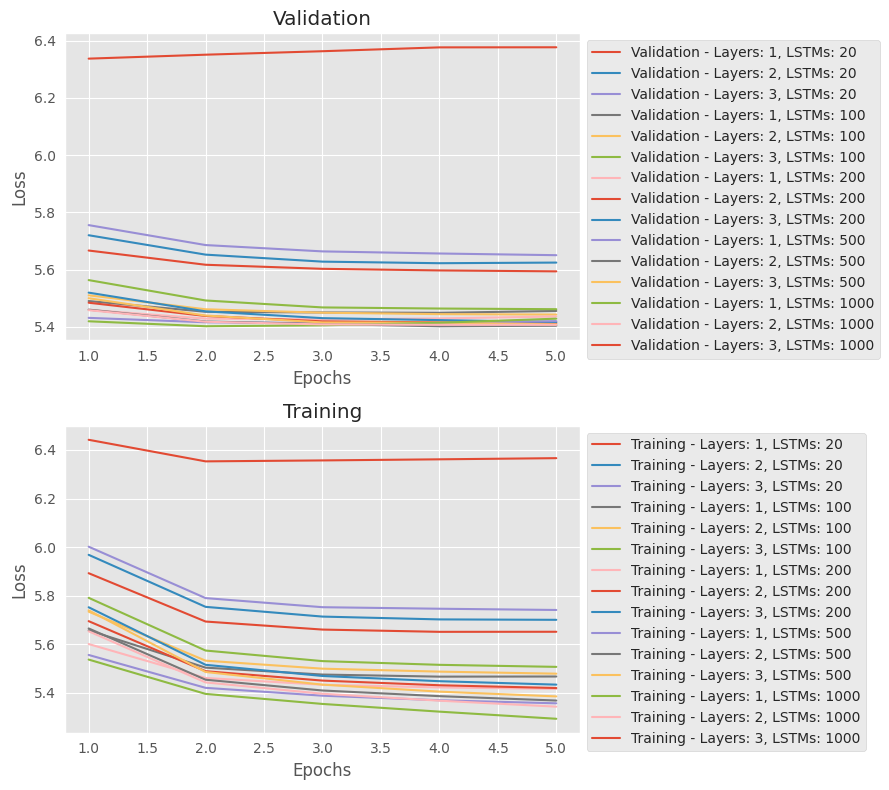

In [200]:
#show training results from different architecutres
plt.figure(figsize=(9,8))
for n,history in enumerate(num_history):
    plt.subplot(2,1,1)
    plt.title('Validation')
    plot_history(history,legend_label[n], show_train=False)
    plt.legend(bbox_to_anchor=(1,1))
    plt.subplot(2,1,2)
    plt.title('Training')
    plot_history(history,legend_label[n], show_valid=False)
    plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()

,Validation Loss,Loss
Label,,
"Layers: 1, LSTMs: 500",5.403611,5.367645
"Layers: 1, LSTMs: 1000",5.406634,5.342438
"Layers: 2, LSTMs: 500",5.408251,5.384692
"Layers: 1, LSTMs: 200",5.413060,5.419282
"Layers: 2, LSTMs: 200",5.416452,5.433204


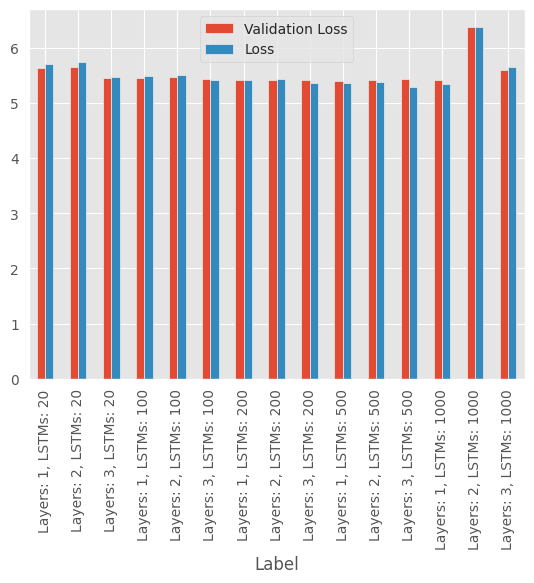

In [201]:
final_val_loss = pd.DataFrame(np.zeros(len(num_history)))
final_loss = pd.DataFrame(np.zeros(len(num_history)))

for n,history in enumerate(num_history):
    final_val_loss.iloc[n-1] = history.history['val_loss'][-1]
    final_loss.iloc[n-1] = history.history['loss'][-1]
    

final_scores = pd.concat([final_val_loss,final_loss,pd.Series(legend_label)],axis=1).set_axis(['Validation Loss','Loss','Label'],axis=1).set_index('Label',drop=True)

final_scores.plot(kind='bar')
final_scores.sort_values('Validation Loss').head()

In [202]:
LSTM_ = 500
layers_ = 1

In [203]:
def train_and_ft(predictors,label,unique_ingredients,max_length, recipe_embeddings,weight_name,callbacks,epochs=50):
    '''Trains and fine tunes LSTM model'''
    #train LSTM and dense layer
    model, history = train_model(LSTM_, layers_, 
                                predictors,
                                label,
                                unique_ingredients,
                                max_length,
                                recipe_embeddings,
                                weight_name,
                                mask_zero=True,
                                device='/cpu:0',
                                epochs=epochs,
                                callbacks=callbacks)
    model.save_weights('training_'+weight_name+'.h5')
    
    #fine tune all layers
    model, fine_history = train_model(LSTM_, layers_, 
                                predictors,
                                label,
                                unique_ingredients,
                                max_length,
                                recipe_embeddings,
                                weight_name,
                                mask_zero=True,
                                device='/cpu:0',
                                transfer=True,
                                lr = 0.0001,
                                epochs=epochs,
                                callbacks=callbacks)
    model.save_weights('fine_'+weight_name+'.h5')
    return model, history, fine_history

In [204]:
'''
model, history, fine_history = train_and_ft(predictors,label,unique_ingredients,max_length_,recipe_embeddings,'weight',callbacks=True)
'''

"\nmodel, history, fine_history = train_and_ft(predictors,label,unique_ingredients,max_length_,recipe_embeddings,'weight',callbacks=True)\n"

In [205]:
'''
with open('histories.pkl','wb') as f:
    pickle.dump([model, history, fine_history],f)
f.close()
'''

"\nwith open('histories.pkl','wb') as f:\n    pickle.dump([model, history, fine_history],f)\nf.close()\n"

In [206]:
with open('histories.pkl','rb') as f:
    _ = pickle.load(f)
    model = _[0]
    history = _[1]
    fine_history = _[2]
f.close()

In [207]:
def get_history(history_, fine_history_):
    epochs_train = len(history_.history['loss'])
    history_.history['loss'].extend(fine_history_.history['loss'])
    history_.history['val_loss'].extend(fine_history_.history['val_loss'])
    epochs_ft = len(history_.history['loss'])
    return epochs_train, epochs_ft, history_

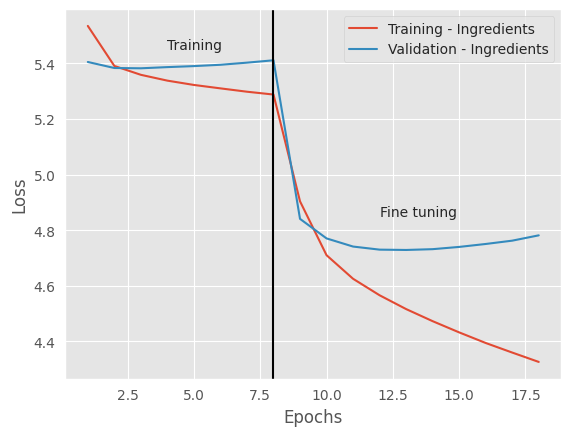

In [208]:
epochs_train, epochs_ft, merged_history = get_history(history, fine_history)
plot_history(merged_history,'Ingredients')
plt.axvline(x=epochs_train,color='k')
plt.legend()
plt.text(4,5.45,'Training')
plt.text(12,4.85,'Fine tuning');

In [209]:
len(unique_names)+1

28954

In [210]:
max_length_name_ = max_length_name_
latent_dim = 128

In [211]:
def build_seq2seq(embed_train=False, 
                max_length_=max_length_, 
                unique_ingredients=unique_ingredients,
                embed_size=embed_size,
                recipe_embeddings=recipe_embeddings,
                latent_dim=latent_dim,
                unique_names=unique_names,
                name_embeddings=name_embeddings,
                max_length_name_ = max_length_name_,
                summary=True
                ):
    '''builds seq2seq network'''
    encoder_inputs = Input(shape=(max_length_+1,),dtype='int32')
    encoder_embedding = Embedding(len(unique_ingredients)+1, embed_size, weights=[recipe_embeddings], trainable=embed_train, mask_zero=True, input_length=max_length_+1)(encoder_inputs)
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_embedding)

    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(max_length_name_,),dtype='int32')
    decoder_embedding = Embedding(len(unique_names)+1, embed_size, weights=[name_embeddings], trainable=embed_train, mask_zero=True, input_length=max_length_name_-1)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs,_,_ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(len(unique_names)+1,activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model_names = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    if summary:
        model_names.summary()
    return encoder_inputs,encoder_outputs, encoder_states,decoder_inputs,decoder_lstm,decoder_outputs, decoder_dense, model_names

In [212]:
name_sequences.shape, recipe_sequences.shape

((231637, 18), (231636, 45))

In [213]:
iterated_recipes_, name_sequences_, name_labels_ = shuffle([recipe_sequences, cut_name, label_name])
iterated_recipes_.shape, name_sequences_.shape, name_labels_.shape

((231636, 45), (231636, 17), (231636, 17))

In [214]:
early_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=0,
    restore_best_weights=True)


In [215]:
# test_range of items
def train_seq2seq(test_range=None,epochs=500, save=True):
    #build, compile and train model using cpu due to issue with masking
    with tf.device('/cpu:0'):    
        #train LSTM components
        print('Model summary:')
        _,_,_,_,_,_,_,model_names = build_seq2seq()
        model_names.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
        
        print('Training LSTMs...')
        model_names.load_weights('name_weights.h5')
        name_history = model_names.fit([iterated_recipes_[:test_range],name_sequences_[:test_range]], name_labels_[:test_range], 
                    batch_size=256, 
                    epochs=epochs, 
                    validation_split=0.1,
                    callbacks = [early_cb])
        name_weights =  model_names.save_weights('name_weights.h5')
        
        #fine tune model
        encoder_inputs,encoder_outputs, encoder_states,decoder_inputs,decoder_lstm,decoder_outputs, decoder_dense,model_names = build_seq2seq(embed_train=True, summary=False)
        
        model_names.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
        
        model_names.load_weights('name_weights.h5')
        
        print('Fine tuning model...')
        fine_history = model_names.fit([iterated_recipes_[:test_range],name_sequences_[:test_range]], name_labels_[:test_range], 
                    batch_size=256, 
                    epochs=epochs, 
                    validation_split=0.1,
                    callbacks = [early_cb])
        
        name_weights =  model_names.save_weights('name_weights.h5')
        
        if save: 
            with open('name_training.pkl','wb') as f:
                pickle.dump([name_history, fine_history, model_names, name_weights, encoder_inputs,encoder_outputs, encoder_states,decoder_inputs,decoder_lstm,decoder_outputs, decoder_dense,model_names],f)
            f.close()
        
        return name_history, fine_history, model_names, name_weights, encoder_inputs,encoder_outputs, encoder_states,decoder_inputs,decoder_lstm,decoder_outputs, decoder_dense,model_names

In [216]:
name_history, fine_history, model_names, name_weights, encoder_inputs,encoder_outputs, encoder_states,decoder_inputs,decoder_lstm,decoder_outputs, decoder_dense,model_names = train_seq2seq(epochs=0)

'''
with open('name_training.pkl','rb') as f: 
    name_history, fine_history, model_names, name_weights, encoder_inputs,encoder_outputs, encoder_states,decoder_inputs,decoder_lstm,decoder_outputs, decoder_dense,model_names = pickle.load(f)
f.close()
'''

Model summary:
Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 45)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 17)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 45, 300)              3723900   ['input_9[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 17, 300)              8686200   ['input_10[0][0]']            
                                                                            

"\nwith open('name_training.pkl','rb') as f: \n    name_history, fine_history, model_names, name_weights, encoder_inputs,encoder_outputs, encoder_states,decoder_inputs,decoder_lstm,decoder_outputs, decoder_dense,model_names = pickle.load(f)\nf.close()\n"

In [217]:
'''
name_loss = name_history.history['loss'][:471]
name_val_loss = name_history.history['val_loss'][:471]
name_accuracy = name_history.history['accuracy'][:471]
name_val_accuracy = name_history.history['val_accuracy'][:471]

with open('name_metrics.pkl','wb') as f:
    pickle.dump([name_loss, name_val_loss, name_accuracy, name_val_accuracy],f)
f.close()
'''
with open('name_metrics.pkl','rb') as f:
    name_loss, name_val_loss, name_accuracy, name_val_accuracy = pickle.load(f)
f.close()

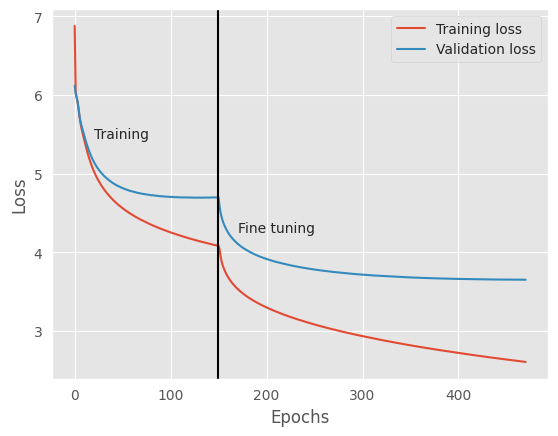

In [218]:
plt.plot(range(len(name_loss)),name_loss,label='Training loss')
plt.plot(range(len(name_val_loss)),name_val_loss,label='Validation loss')
plt.axvline(x=149,color='k')
plt.legend()
plt.text(20,5.45,'Training')
plt.text(170,4.25,'Fine tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss');

<h2><br></h2>
<h2>Predicting names</h2>

In [219]:
def decoder(latent_dim, embed_size=embed_size, unique_names=unique_names,name_embeddings=name_embeddings,max_length_name_=max_length_name_, decoder_inputs=decoder_inputs, decoder_lstm=decoder_lstm, decoder_dense=decoder_dense):
    '''Creates decoder model'''
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_embedding = Embedding(len(unique_names)+1, embed_size, weights=[name_embeddings], trainable=False, mask_zero=True, input_length=max_length_name_)(decoder_inputs)
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)
    return decoder_model

In [220]:
def encoder(encoder_inputs, encoder_states):
    '''Creates encoder model'''
    encoder_model = Model(encoder_inputs, encoder_states)
    return encoder_model

In [221]:
def sample(preds, temperature=0.5):
    '''Selects next word in names with temperature controlling the variability.'''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [223]:
suggestions, text = cook_for_me('rice',model)
encoder_model = encoder(encoder_inputs, encoder_states)
#encoder_model(np.array([suggestions[0]]))

In [224]:
def decode_sequence(input_seq):
    ''''''
    #load models 
    encoder_model = encoder(encoder_inputs, encoder_states)
    decoder_model = decoder(latent_dim)
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq,verbose=0)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,17))
    target_seq[0,-1] = 1 #Assigning first word to be 'sos'
    stop_condition = True
    decoded_sentence = ''
    prev_char = ' '
    while stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value,verbose=0)# Sample a token
        #sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #sampled_token_index = np.random.choice(len(output_tokens[0,-1,:]),p=output_tokens[0,-1,:])
        sampled_token_index = sample(output_tokens[0,-1,:])
        sampled_char = list(tokenizer_names.word_index.keys())[sampled_token_index-1]
        if (sampled_char != prev_char)&(sampled_char != 'eos'):
            decoded_sentence += sampled_char+' '# Exit condition: either hit max length
        prev_char = sampled_char
        # or find stop character.

        if (sampled_char == 'eos' or len(decoded_sentence) > 100):
            stop_condition = False# Update the target sequence (of length 1).
            
        #updating target sequence
        target_seq = target_seq[0].tolist()
        target_seq.append(sampled_token_index)
        target_seq.pop(0)
        target_seq = np.array([target_seq])
        
        states_value = [h, c]
    return decoded_sentence.strip().title()

<h2><br></h2>
<h2>Predicting recipes</h2>

In [225]:
def pad_sequences(token_list, max_length=max_length_):
    '''pad sequences (built in function returns a recursion error)'''
    padded_sequence = []
    zeros = (max_length-len(token_list))
    padded = [int(0) for zero in range(zeros+1)]
    padded.extend(token_list)
    return padded

In [226]:
def cook_for_me(seed_text, model):
    '''Suggests additional ingredients to add'''
    next_words = 5
    words_out = []
    token_list = []

    seed_text = seed_text.split('and')
    for word in seed_text:
        word = word.strip()
        token_ = tokenizer.texts_to_sequences([word])[0]
        token_list.extend(token_)
    token_list = pad_sequences(token_list)[2:]

    while next_words > 0:
        model.load_weights('fine_weight.h5')
        proba = model.predict(np.array(token_list).reshape(-1,43),verbose=0)
        predicted = np.argmax(proba, axis=1)
        new_token = int(predicted[0])
        word = list(tokenizer.word_index.keys())[int(predicted[0]-1)]
        words_out.append(word)
        token_list.append(new_token)
        token_list.pop(0)
        next_words -= 1
    token_list = [pad_sequences(token_list)]
    words_out = list(set(words_out))
    string_out = 'Why not try adding some '+', '.join(words_out[:-1])+' and '+words_out[-1]+'?'
    return token_list, string_out

In [227]:
def make_suggestions(ingredients_in_stock):
    '''Suggests additional ingredients to use and names the recipe'''
    for ingredient in ingredients_in_stock:
        greeting = 'For '+ingredient.upper() +' let me see... '
        print(greeting)
        suggestions, text = cook_for_me(ingredient,model)
        #print(suggestions)
        print(text.replace('flmy','flour'))
        print('I call it...')
        named = decode_sequence(suggestions)
        print(named)
        print(' ')

In [236]:
#defining three levels to test suggestion models
#easy
single_ingredients = [
    'cherry',
    'lettuce',
    'mirin',
    'pineapple'
    ]

#medium
reasonable_combos = [
    'chicken and rice',
    'chicken and rice and salsa',
    'banana and cinnamon',
    'egg and sugar'
    ]

#hard
odd_pairings = [
    'chicken and rice and grapefruit',
    'chocolate and beans',
    'marshmallow and cantaloupe',
    'spinach and cinnamon'
    ]

In [239]:
make_suggestions(single_ingredients)

For CHERRY let me see... 
Why not try adding some cinnamon, egg, butter, flour and sugar?
I call it...
Cherry Crisp
 
For LETTUCE let me see... 
Why not try adding some green pepper, feta cheese, tomato, scallion and cucumber?
I call it...
Mixed Salad
 
For MIRIN let me see... 
Why not try adding some sesame oil, fresh ginger, garlic clove, soy sauce and sugar?
I call it...
Japanese Dipping Dressing
 
For PINEAPPLE let me see... 
Why not try adding some cornstarch, lemon juice, salt, water and sugar?
I call it...
Pineapple Jam
 


In [240]:
make_suggestions(reasonable_combos)

For CHICKEN AND RICE let me see... 
Why not try adding some chicken broth, onion, potato, celery and carrot?
I call it...
Chicken Soup
 
For CHICKEN AND RICE AND SALSA let me see... 
Why not try adding some tortilla, pepper, cheese, salt and water?
I call it...
Easy Chicken Tortilla
 
For BANANA AND CINNAMON let me see... 
Why not try adding some clove, salt, allspice, ginger and nutmeg?
I call it...
Banana Bread
 
For EGG AND SUGAR let me see... 
Why not try adding some baking powder, vanilla, salt, milk and flour?
I call it...
Grandma Cake
 


In [241]:
make_suggestions(odd_pairings)

For CHICKEN AND RICE AND GRAPEFRUIT let me see... 
Why not try adding some garlic, ginger, water, brown sugar and soy sauce?
I call it...
Chicken And Broccoli
 
For CHOCOLATE AND BEANS let me see... 
Why not try adding some baking powder, egg, butter, flour and sugar?
I call it...
Chocolate Brownies
 
For MARSHMALLOW AND CANTALOUPE let me see... 
Why not try adding some blueberry, banana, strawberry and pineapple?
I call it...
Fruit
 
For SPINACH AND CINNAMON let me see... 
Why not try adding some pepper, salt, egg, nutmeg and milk?
I call it...
Spinach And Feta Cheese
 


In [ ]:
#input ingredients seperated by ' and ' to test models yourself
user_ingredients = input()
user_ingredients = user_ingredients.lower().strip()
make_suggestions([user_ingredients])